# Switching to Sampling for Switching

In this document I'll demonstrate how sampling can help you solve a simple switchpoint-timeseries task. We'll also review how to code this into PyMC3. 

# Wait Sampling?! 

If you're from the machine learning school, you might be slightly suprised that sampling can be used as a modelling technique. Usually one might define some loss function that describes how well your model fits your dataset and you just optimize the parameter of that loss followed by lots of crossvalidation. What I'll be describing in this document is a different approach to modelling. 

Instead of taking a model and fitting it, we're interested in finding: 

$$ \mathbb{P}(\theta | D) $$ 

where $D$ is the data given to us and $\theta$ is the set of parameters that need to be chosen for the model. These might be the regression coefficients for a linear regression or even the weights of a neural network. Note that we're not interested in finding the best value of $\theta$, instead we want to know the distribution of $ \mathbb{P}(\theta | D)$ because we want to understand the uncertainties in our model. In this framework, we're putting more uncertainty in our model and trusting the data more as the only source of information. 


# Data 

This might still sound a bit vague, so let's first generate the data that we want to analyse. An example usually helps a lot in explaining things. 

In [103]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
np.random.seed(42)

x1 = np.random.randn(50) - 1
x2 = np.random.randn(150)*1.4 + 1
x = np.hstack([x1, x2])
time = np.arange(len(x))

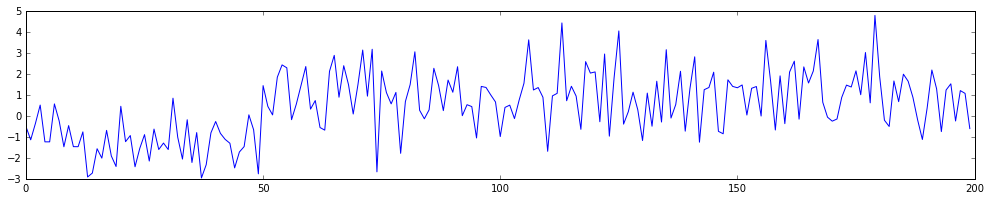

In [104]:
plt.figure(figsize=(17,3))
plt.plot(time, x)

This is a timeseries with a switchpoint in it. With a blind eye, you should be able to verify that there is a changepoint. The goal for us is to find out where the changepoint is as well as derive the mean and variance of the timeseries before and after the changepoint. In this case $\theta = \{ s, \mu_1, \mu_2, \sigma_1, \sigma_2\}$, where $s$ is the moment in time where the switch occured, $\mu_1, \sigma_1$ correspond to the mean and variance before the switchpoint and $\mu_2, \sigma_2$ correspond to the mean and variance after the switchpoint. 

This means we can translate $\mathbb{P}(\theta | D)$ into; 

$$ \mathbb{P}(s, \mu_1, \mu_2, \sigma_1, \sigma_2 | D) $$ 

The nice thing about being a bayesian is that you can use maths to help you think about what this means. 

\begin{align} 
\mathbb{P}(s, \mu_1, \mu_2, \sigma_1, \sigma_2 | D) &\propto \mathbb{P}(D | s, \mu_1, \mu_2, \sigma_1, \sigma_2)\mathbb{P}(s, \mu_1, \mu_2, \sigma_1, \sigma_2)\\ 
& = \Pi_i \mathbb{P}( y_i | s, \mu_1, \mu_2, \sigma_1, \sigma_2)\mathbb{P}(s, \mu_1, \mu_2, \sigma_1, \sigma_2)
\end{align}

Now let's think about the two parts in that equation 

### Part 1: $\Pi_i \mathbb{P}( y_i | s, \mu_1, \mu_2, \sigma_1, \sigma_2)$

This part of the equation describes how likely it is that we see a datapoint $y_i$ in our dataset given the model parameters. How would we describe the likelihood of a point $y_i$ given the model parameters? We are free to model it any way we like, but for our setting I feel that this seems reasonable. 

$$ \mathbb{P}( y_i | s, \mu_1, \mu_2, \sigma_1, \sigma_2) = 
    \begin{cases} 
        y_i \sim N(\mu_1, \sigma_1) &\mbox{if } i \leq s \\ 
        y_i \sim N(\mu_2, \sigma_2) & \mbox{if } i > s 
    \end{cases}$$ 

### Part 2: $\mathbb{P}(s, \mu_1, \mu_2, \sigma_1, \sigma_2)$

This part of the equation describes our prior belief; what do we know about the parameters before looking at any data? 

You might be temped to think; "I don't know anything! Putting data into the model is bias!". This thought is not  unreasonable, but then again; every model has bias. In this case I think it is fair to argue that we actually know some things; 

- We know that the switchpoint $s$ is an integer between 0 and the length of the timeseries. 
- From just eyeballing the timeseries, it seems like all the $\mu$ values are probably somewhere in $[-2, 2]$. It also seems like the $\sigma$ is probably not too big either. 

Using this information in our model does not sound too unreasonble to me. In fact, being able to use this information seems like a reasonable requirement. I may even go as far as suggesting that it is a bit flawed if your model doesn't allow you to do this. 

# Yes, Sampling 

So far, we have defined our model mathematically but we have done nothing with it algorithmically. At this stage very little is different from the standard machine learning approach. We have a mathematical setup, albeit one with a bit of our own bias in it and we are just about to search for the best values of $s, \mu_1, \mu_2, \sigma_1, \sigma_2$. People might complain about the need to do a bit of math but that's it. Just use gradient descrent and you'd be done right? I'll give two reasons why this might be a suboptimal way of thinking about it.

- The loss function of our model is not convex and this is the case in general. There is inherent risk in that we are not able to find a set of optimal parameters and that we will end up using a flawed model. Even when the model is modest in size like here.  
- We will have no information known to us about the uncertainty of our paramters. In this particular example, the quantiles of $s$ might be more valuable to me than the most likely value of $s$.

So instead of finding an optimal solution, we will try to create samples from $\mathbb{P}(s, \mu_1, \mu_2, \sigma_1, \sigma_2 | D)$. The hope is, that after many many samples, we get an idea of the distribution of the parameters. The nice thing about sampling is that we do not need to worry about deriving the distribution with maths. The nasty thing is that we may need to sample much data before we achieve any convergence. 

A popular tactic for sampling is to take a MCMC approach. The idea is that we start out at some random allocation of $s, \mu_1, \mu_2, \sigma_1, \sigma_2$ and then make mini steps that are determined by the likelihood. If a step is likely compared to the current parameters we take it, otherwise we might reconsider stepping somewhere else. This approach is strictly different than genetic algorithms in the sense that we are intend on also visiting areas with low likelihood (but with a low probability of staying there long). The idea behind the sampler is to approximate the underlying distribution, not to merely find optimal values.

## PYMC3 

In the python world, there are three libraries to do this sort of probibalistic sampling in:

- PyMC3 
- emcee 
- PyStan 

I'll be using PyMC3 here but for no particular reason whatsoever. Emcee seems like a worthwhile alternative in the sense that it may offer a bit more speed because it comes with easy parallisation options but it has less distributions. Stan is pretty great too, but I have some [minor issues](http://stackoverflow.com/questions/35928204/stan-error-casting-parameter-to-int) with the api and documentation. 

In the code below you'll see all the math describe above written into code.

In [105]:
import pymc3 as pm
basic_model = pm.Model()
with basic_model:
    # define all of my priors
    mu1 = pm.Normal('mu1', mu=0, sd=2)
    mu2 = pm.Normal('mu2', mu=0, sd=2)
    sigma1 = pm.HalfNormal('sigma1', sd=2)
    sigma2 = pm.HalfNormal('sigma2', sd=2)
    switchpoint = pm.DiscreteUniform('switchpoint', 0, time.max())

    # formally define the effect from the switchpoint
    tau_mu = pm.switch(time >= switchpoint, mu2, mu1)
    tau_sigma = pm.switch(time >= switchpoint, sigma2, sigma1)
    
    # define the relationship between observed data and input
    y = pm.Normal('y1', mu=tau_mu, sd=tau_sigma, observed=x)
    trace = pm.sample(10000)

Applied log-transform to sigma1 and added transformed sigma1_log to model.
Applied log-transform to sigma2 and added transformed sigma2_log to model.
Assigned NUTS to mu1
Assigned NUTS to mu2
Assigned NUTS to sigma1_log_
Assigned NUTS to sigma2_log_
Assigned Metropolis to switchpoint
 [-----------------100%-----------------] 10000 of 10000 complete in 8.1 sec

With all this sampling behind us, we can see the history of the sampler as well as a histogram of our parameter estimates. 

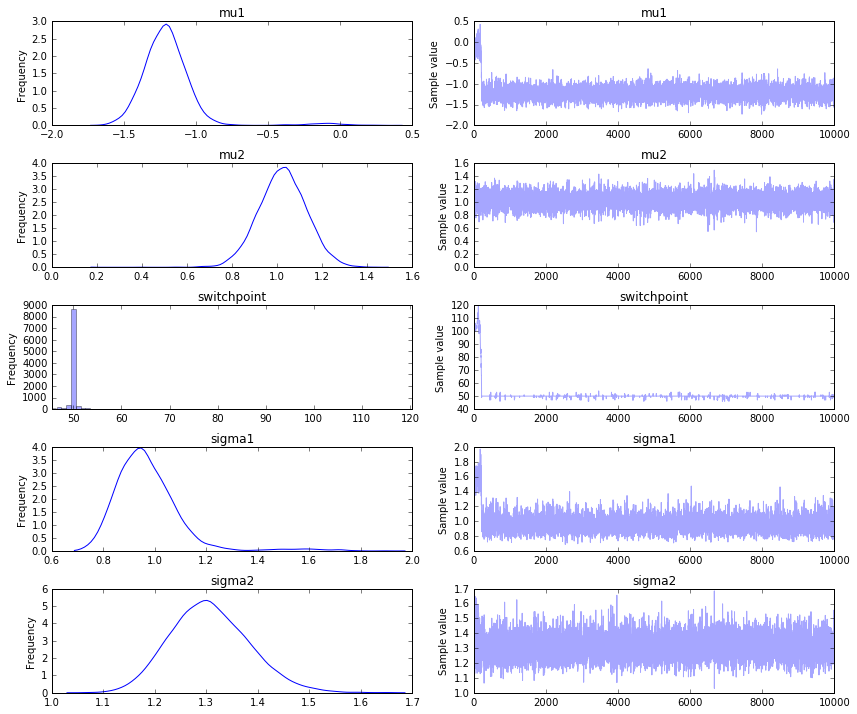

In [106]:
_ = pm.traceplot(trace)

We seem to find the appropriate switchpoint, which is nice. More sampling would give more convergence and it would help if we had more data too. Note that if the difference between before and after the switchpoint is very subtle it will become rather hard infer the correct switchpoint. 

We may also attempt a maximum aposteri approach, this has risks when the posteriori function becomes less and less convex. 

In [107]:
pm.find_MAP(model=basic_model)

{'mu1': array(-0.10742096434465985),
 'mu2': array(1.0232122174722886),
 'sigma1_log_': array(0.44914063604250837),
 'sigma2_log_': array(0.2821837005109984),
 'switchpoint': array(99)}

Notice:

- that the MAP estimate gives us very little information compared to the estimated distribution that we get out from sampling.
- the switchpoint parameter is **way** off, most likely due to the nonconvexity. 

# Multiple Switchpoints

We can extend the model very easily to contain multiple switchpoints too. In fact, let's make this switchpoint interesting. Let's assume that after the second switchpoint the timeseries switches back into it's original generative form. 

In [114]:
x1 = np.random.randn(150)
x2 = np.random.randn(150)*2 + 4
x3 = np.random.randn(150)
x_adv = np.hstack([x1, x2, x3])
time_adv = np.arange(len(x))

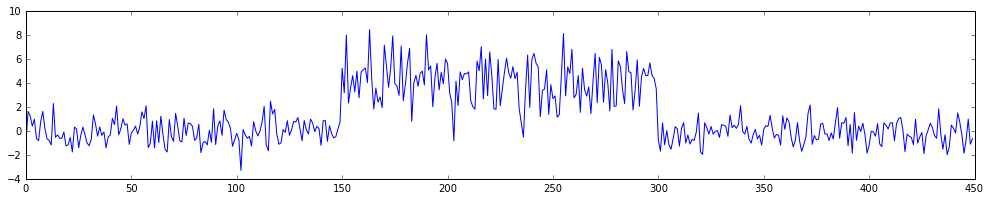

In [115]:
plt.figure(figsize=(17,3))
plt.plot(time, x)

In [116]:
adv_model = pm.Model()
with adv_model:
    # define all of my priors
    mu1 = pm.Normal('mu1', mu=0, sd=4)
    mu2 = pm.Normal('mu2', mu=0, sd=4)
    sigma1 = pm.HalfNormal('sigma1', sd=4)
    sigma2 = pm.HalfNormal('sigma2', sd=4)
    switchpoint1 = pm.DiscreteUniform('switchpoint1', 0, time.max() - 1)
    switchpoint2 = pm.DiscreteUniform('switchpoint2', switchpoint1, time.max())

    # formally define the effect from the switchpoints, be careful about order! 
    tau_mu1 = pm.switch(time >= switchpoint1, mu2, mu1)
    tau_mu2 = pm.switch(time >= switchpoint2, mu1, tau_mu1)
    tau_sigma1 = pm.switch(time >= switchpoint1, sigma2, sigma1)
    tau_sigma2 = pm.switch(time >= switchpoint2, sigma1, tau_sigma1)
    
    # define the relationship between observed data and input
    y = pm.Normal('y1', mu=tau_mu2, sd=tau_sigma2, observed=x)
    adv_trace = pm.sample(5000)

Applied log-transform to sigma1 and added transformed sigma1_log to model.
Applied log-transform to sigma2 and added transformed sigma2_log to model.
Assigned NUTS to mu1
Assigned NUTS to mu2
Assigned NUTS to sigma1_log_
Assigned NUTS to sigma2_log_
Assigned Metropolis to switchpoint1
Assigned Metropolis to switchpoint2
 [-----------------100%-----------------] 5000 of 5000 complete in 23.9 sec

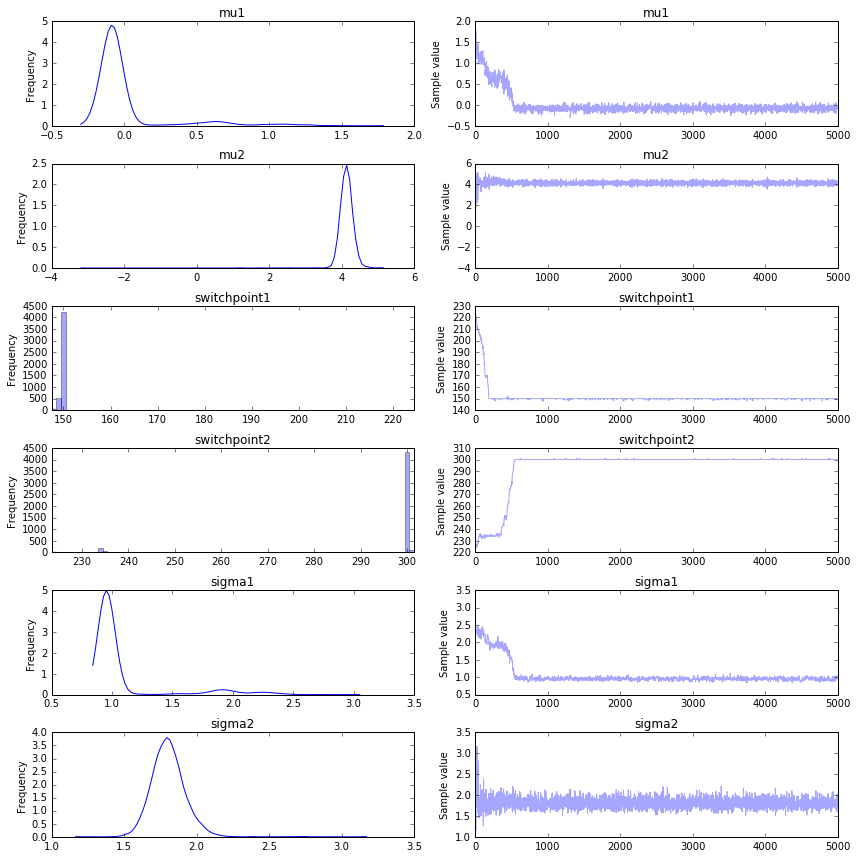

In [117]:
_ = pm.traceplot(adv_trace)

It seems like we get a quicker convergence in what appears to be a more complex model. This might appear counter intuitive but be mindful: 

- this timeseries has more data and the differences between two switchpoints are less subtle. 
- because we know that the generative process before the first switchpoint and after the last switchpoint are the same, we have more information known to us.
- the stacktrace has a bit of visual bias. You'll notice that in the initial samples we see to be sampling from a different distribution than at the end. These samples are also represented in the histogram which gives the impression that the distributions are very thin. We can plot the traces again, this time omitting the first 1000 samples and get a better image. It is a good practice to ignore the first 1000-ish of generated samples to reduce the initial value bias.

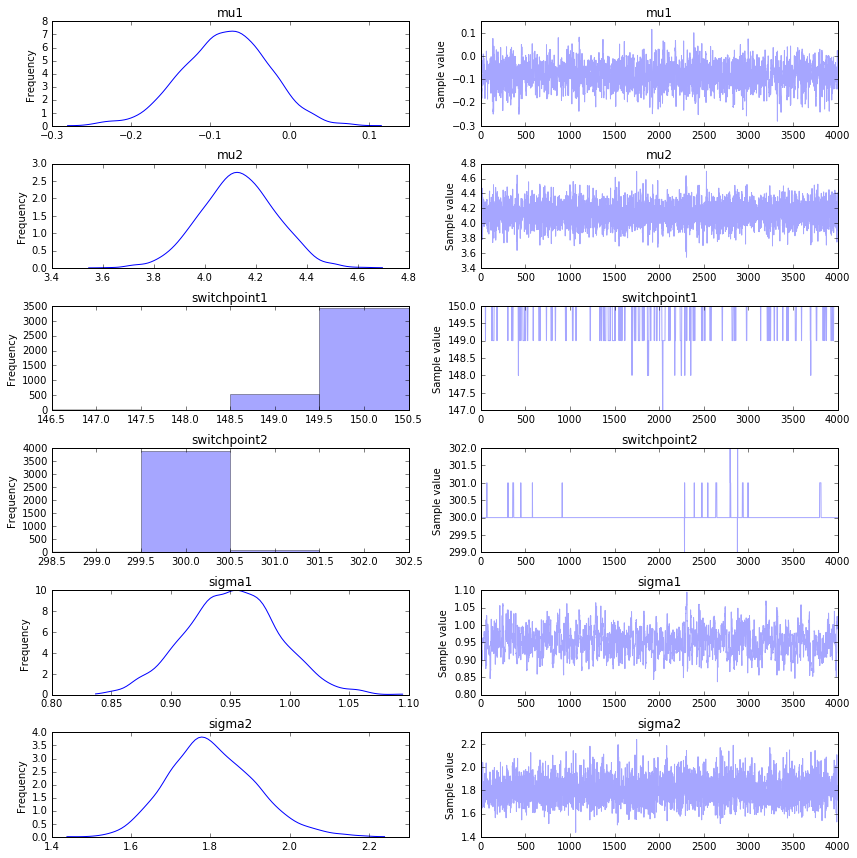

In [112]:
_ = pm.traceplot(trace[1000:])

Again, the MAP fails when it comes to switchpoints. 

In [113]:
pm.find_MAP(model=basic_model)

{'mu1': array(1.3253008730440974),
 'mu2': array(0.0),
 'sigma1_log_': array(0.8639975314985741),
 'sigma2_log_': array(1.3862943591402144),
 'switchpoint1': array(224),
 'switchpoint2': array(224)}

# Conclusion 

Not everybody enjoys this sampling approach. Some people don't like doing the math (bad reason) and other people worry about the convergence and training speed (very good reason). The thing that appeals to me is the flexibility of the modelling technique and some of the intellectual freedom that it gives me as a data person. 

I am very flexible in designing my model with this technique. I'm not confined to a predefined ML model and I can design the mold of my own model. Where in the standard ML-world I sometimes feel like all of my time is spent in designing features for a model I can now spend more time designing a model around the features that I have. 

Liberating! Though the worry about convergence is very ligitimate. Hopefully the field of variational inference will find a solution to that someday. 